In [1]:
import os

import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from fooling_LIME_SHAP_Interface.adversarial_model_toolbox import AdversarialModelToolbox
from fooling_LIME_SHAP_Interface.util.explainer_type import ExplainerType
from fooling_LIME_SHAP_Interface.util.ml_type import MLType

In [2]:
TRAIN_TEST_SPLIT = 0.2
SEED = 666

dataset_name = 'HousingData'
input_ids = list(range(13))
categorical_input_ids = []
output_id = 13
biased_id = 11

In [3]:
# Load dataset
house_df = pd.read_csv(os.path.join("datasets", dataset_name + ".csv"))
house_df = house_df.fillna(0)

# Split input and output
y_df = house_df.iloc[:, output_id]
x_df = house_df.iloc[:, input_ids]

scaler = MinMaxScaler()
scaler.fit(x_df.to_numpy())
x = scaler.transform(x_df.to_numpy())

# Create train and test data
x_train, x_test, y_train, y_test = train_test_split(x, y_df.to_numpy(), test_size=TRAIN_TEST_SPLIT, random_state=SEED)

# Create training data without biased column
ux_train = x_train.copy()
ux_train[:, input_ids.index(biased_id)] = 0
ux_test = x_test.copy()
ux_test[:, input_ids.index(biased_id)] = 0

In [4]:
biased_ml = RandomForestRegressor(random_state=SEED)
biased_ml.fit(x_train, y_train)
print("Accuracy of biased model: {0:3.2}".format(biased_ml.score(x_test, y_test)))

Accuracy of biased model: 0.82


In [5]:
unbiased_ml = RandomForestRegressor(random_state=SEED)
unbiased_ml.fit(ux_test, y_test)
print("Accuracy of unbiased model: {0:3.2}".format(unbiased_ml.score(ux_test, y_test)))

Accuracy of unbiased model: 0.96


Calculating Lime explanations
Original Lime explanation:


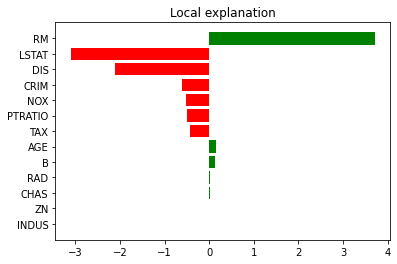

Adversarial Lime explanation:


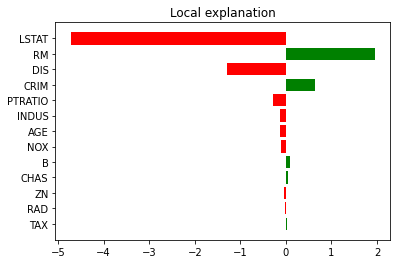

Prediction fidelity between original and adversarial model: 1.0


In [6]:
adv = AdversarialModelToolbox(biased_model=biased_ml, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test,
                              input_feature_names=house_df.columns[input_ids].tolist(),
                              categorical_feature_indices=[input_ids.index(cat_id) for cat_id in categorical_input_ids],
                              unbiased_model=unbiased_ml,
                              biased_id=input_ids.index(biased_id), fool_explainer_type=ExplainerType.LIME,
                              ml_type=MLType.REGRESSION, seed=SEED)
adv.train()
adv.get_explanations()

Calculating Shap explanations


  0%|          | 0/1 [00:00<?, ?it/s]

Original Shap explanation:


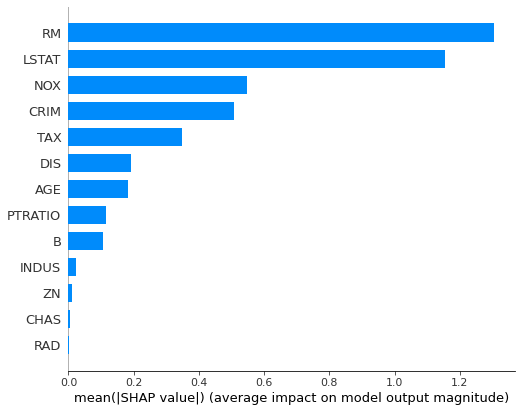

  0%|          | 0/1 [00:00<?, ?it/s]

Adversarial Shap explanation:


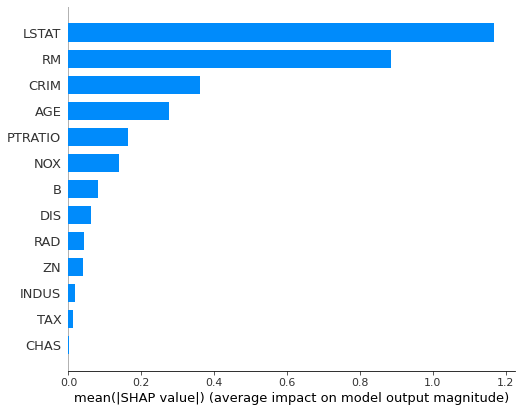

Prediction fidelity between original and adversarial model: 0.93


In [7]:
adv = AdversarialModelToolbox(biased_model=biased_ml, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test,
                              input_feature_names=house_df.columns[input_ids].tolist(),
                              categorical_feature_indices=[input_ids.index(cat_id) for cat_id in categorical_input_ids],
                              unbiased_model=unbiased_ml,
                              biased_id=input_ids.index(biased_id), fool_explainer_type=ExplainerType.SHAP,
                              ml_type=MLType.REGRESSION, seed=SEED)
adv.train()
adv.get_explanations()